## Análisis de IPs reportadas como atacantes por SSH
### Extracción de IPs
Para la realización de este análisis la cátedra proporcionó una lista de IPs que fueron reportadas por conexiones SSH y ataques DDoS

In [134]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/SSH.txt > data/IPsSSH.txt

In [135]:
with open("data/IPsSSH.txt") as ips:
    ipSSH = ips.read()
    
ipSSH = ipSSH.replace("\n", " ").split()
ipSSH

['54.144.244.57',
 '188.166.216.223',
 '220.94.228.162',
 '218.92.0.99',
 '116.193.159.2',
 '109.117.92.13',
 '167.99.112.43',
 '89.248.163.219',
 '143.198.204.177',
 '61.177.173.45',
 '8.222.204.225',
 '220.135.119.188']

### Importamos la implementación de las peticiones a la API

In [136]:
#| code-fold: true
!cp ../app/modulos/abuseIPDB.py modulos/abuseIPDB.py

In [137]:
#Importo los modulos necesarios
from modulos.abuseIPDB import AbuseIPDB
import pandas as pd

In [138]:
#Construyo el objeto
apiAbuse = AbuseIPDB()

In [139]:
#| code-fold: true
import os

In [140]:
#Declaro las keys de la info que devuelve mi implementación de requests
keys = ['esPublica', 'estaEnWhitelist', 'scoreAbuso', 'pais', 'codigoPais', 'isp', 'tipoDeUso', 'ultimoReporte']

diccDf = {'ip' : []}

if os.path.isfile("data/ipSSH.csv"):
    
    df = pd.read_csv("data/ipSSH.csv")
    
else:
    for ip in ipSSH:
        diccDf['ip'].append(ip)
        info = apiAbuse.getInfo(ip)
        for key in keys:
            if key in diccDf:
                diccDf[key].append(info[key])
            else:
                diccDf[key] = [info[key]]

        df = pd.DataFrame(data=diccDf)


In [141]:
df

,Unnamed: 0,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp,tipoDeUso,ultimoReporte
0,0,54.144.244.57,True,False,58,NaN,US,Amazon Data Services NoVa,Data Center/Web Hosting/Transit,2023-05-24T06:13:13+00:00
1,1,188.166.216.223,True,False,100,NaN,SG,DigitalOcean LLC,Data Center/Web Hosting/Transit,2023-05-24T22:06:28+00:00
2,2,220.94.228.162,True,False,100,NaN,KR,KT Corporation,NaN,2023-05-25T07:31:37+00:00
3,3,218.92.0.99,True,False,100,NaN,CN,ChinaNet Jiangsu Province Network,Data Center/Web Hosting/Transit,2023-05-25T13:37:54+00:00
4,4,116.193.159.2,True,False,100,NaN,HK,Pacswitch Globe Telecom Limited,Data Center/Web Hosting/Transit,2023-05-25T13:27:42+00:00
5,5,109.117.92.13,True,False,100,NaN,IT,Vodafone Italia S.p.A.,NaN,2023-05-25T12:52:03+00:00
6,6,167.99.112.43,True,False,100,NaN,US,DigitalOcean LLC,Data Center/Web Hosting/Transit,2023-05-25T06:00:10+00:00
7,7,89.248.163.219,True,False,100,NaN,NL,FiberXpress BV,Fixed Line ISP,2023-05-25T12:40:37+00:00
8,8,143.198.204.177,True,False,100,NaN,SG,DigitalOcean LLC,Data Center/Web Hosting/Transit,2023-05-24T16:11:13+00:00
9,9,61.177.173.45,True,False,100,NaN,CN,ChinaNet Jiangsu Province Network,Data Center/Web Hosting/Transit,2023-05-25T13:35:00+00:00


In [142]:
df.to_csv("data/ipSSH.csv")

### Índices de abuso

In [143]:
recuento = df["scoreAbuso"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,100,11
1,58,1


### Análisis de procedencia

In [144]:
import pycountry

In [145]:
df['pais'] = df['codigoPais'].apply(lambda codigo: pycountry.countries.get(alpha_2=codigo).name)
dfgdp = df.copy()
dfgdp['codigoPais'] = df['pais'].apply(lambda nombre: pycountry.countries.search_fuzzy(nombre)[0].alpha_3)

In [146]:
dfgdp

,Unnamed: 0,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp,tipoDeUso,ultimoReporte
0,0,54.144.244.57,True,False,58,United States,USA,Amazon Data Services NoVa,Data Center/Web Hosting/Transit,2023-05-24T06:13:13+00:00
1,1,188.166.216.223,True,False,100,Singapore,SGP,DigitalOcean LLC,Data Center/Web Hosting/Transit,2023-05-24T22:06:28+00:00
2,2,220.94.228.162,True,False,100,"Korea, Republic of",KOR,KT Corporation,NaN,2023-05-25T07:31:37+00:00
3,3,218.92.0.99,True,False,100,China,CHN,ChinaNet Jiangsu Province Network,Data Center/Web Hosting/Transit,2023-05-25T13:37:54+00:00
4,4,116.193.159.2,True,False,100,Hong Kong,HKG,Pacswitch Globe Telecom Limited,Data Center/Web Hosting/Transit,2023-05-25T13:27:42+00:00
5,5,109.117.92.13,True,False,100,Italy,ITA,Vodafone Italia S.p.A.,NaN,2023-05-25T12:52:03+00:00
6,6,167.99.112.43,True,False,100,United States,USA,DigitalOcean LLC,Data Center/Web Hosting/Transit,2023-05-25T06:00:10+00:00
7,7,89.248.163.219,True,False,100,Netherlands,NLD,FiberXpress BV,Fixed Line ISP,2023-05-25T12:40:37+00:00
8,8,143.198.204.177,True,False,100,Singapore,SGP,DigitalOcean LLC,Data Center/Web Hosting/Transit,2023-05-24T16:11:13+00:00
9,9,61.177.173.45,True,False,100,China,CHN,ChinaNet Jiangsu Province Network,Data Center/Web Hosting/Transit,2023-05-25T13:35:00+00:00


In [147]:
import geopandas as gpd
import matplotlib.pyplot as plt

mapa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

::: {.callout-note header=false}
Todas estas librerias utilizan convenciones, por lo cual es importante checkear que esten presentes todos los paises que queremos plotear
:::

In [148]:
#| code-fold: true
import numpy as np

In [149]:
print(np.unique(dfgdp["codigoPais"].loc[~dfgdp["codigoPais"].isin(mapa["iso_a3"])]))

['HKG' 'SGP']


Pude notar que tanto Hong Kong, como Singapur no estan representadas en el mapa mundi por ser ciudades. Por ello, debo cargarlas desde otro dataset


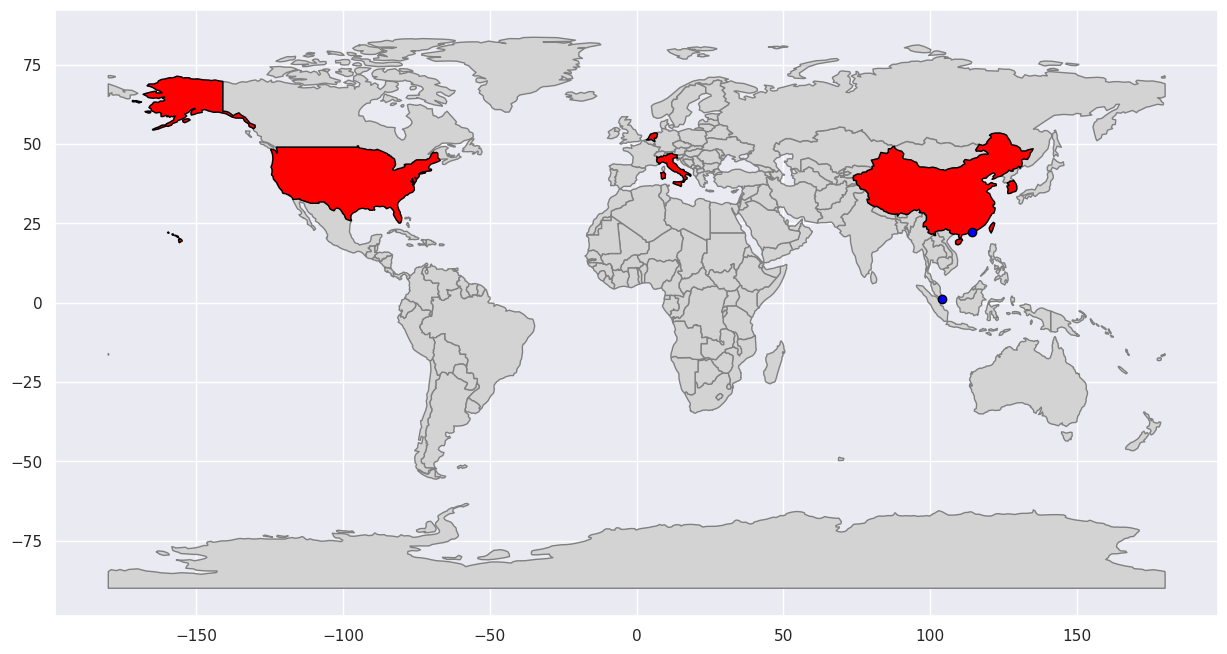

In [150]:
#| label: fig-mapa
#| fig-cap: Mapa con los lugares del que proceden las IPs
paisesMarcados = mapa[mapa['iso_a3'].isin(dfgdp["codigoPais"])]

fig, ax = plt.subplots(figsize=(15, 10))

mapa.plot(ax=ax, edgecolor='grey', color='lightgrey')
paisesMarcados.plot(ax=ax, edgecolor='black', color='red')

ciudades = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

singapur = ciudades[ciudades['name'] == 'Singapore']
hongkong = ciudades[ciudades['name'] == 'Hong Kong']

singapur.plot(ax=ax, edgecolor='black', color='blue')
hongkong.plot(ax=ax, edgecolor='black', color='blue')

plt.show()

In [151]:
import plotly.express as px

In [152]:
import seaborn as sns

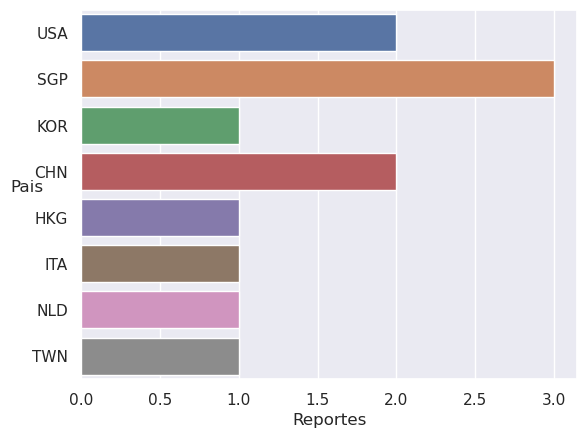

In [153]:
#| label: fig-countplot
#| fig-cap: Pais vs Nro de reportes
sns.set(style='darkgrid')
sns.countplot(data=dfgdp, y="codigoPais")
ylabel = plt.ylabel("Pais", rotation='horizontal')
plt.xlabel("Reportes")
plt.show()

In [154]:
recuento = dfgdp["codigoPais"].value_counts().to_dict()

dfPlot = pd.DataFrame(data={"codigoPais": list(recuento.keys()), "Reportes": list(recuento.values())})
dfPlot

fig = px.scatter_geo(dfPlot, locations="codigoPais", color="codigoPais", size="Reportes",
                     projection="equirectangular")
fig.write_image("data/plotlySSH.png")

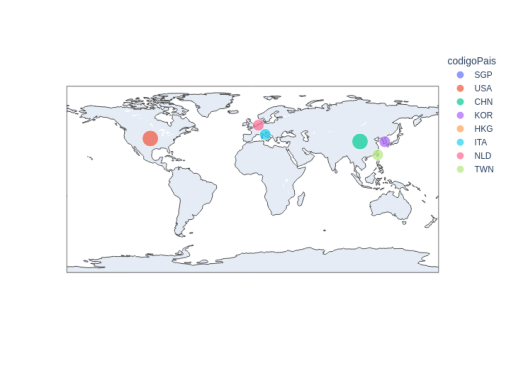

In [155]:
#| label: fig-scatergeo
#| fig-cap: Scatterplot con tamaño en función de número de reportes
from PIL import Image 

image = np.asarray(Image.open('data/plotlySSH.png'))
plt.imshow(image)
plt.grid(False)
plt.axis(False)
plt.show()

In [156]:
recuento = df["pais"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,Singapore,3
1,United States,2
2,China,2
3,"Korea, Republic of",1
4,Hong Kong,1
5,Italy,1
6,Netherlands,1
7,"Taiwan, Province of China",1


### Análisis de frecuencia
Para así poder de tratar de identificar cierto patron asociado a la hora de ataque. 

#### Extracción de información

In [157]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/SSH.txt > data/IPsSSH.txt

patron = "[a-z]{3}\/[0-9]{2}\/[0-9]{4}"
!grep -Eo "$patron" data/SSH.txt >> data/IPsSSH.txt

patron = "[0-9]{2}\:[0-9]{2}\:[0-9]{2}"
!grep -Eo "$patron" data/SSH.txt >> data/IPsSSH.txt

In [158]:
with open("data/IPsSSH.txt") as ips:
    data = ips.read()
    data = data.replace("\n", " ").split()

In [159]:
for i in range(int(len(data)/3)):
    data[i] = data[i] + " " + data[int(len(data)/3)+i] + " " + data[(int(len(data)/3))*2+i]

In [160]:
data = data[:int(len(data)/3)]

In [161]:
for i in data:
    print(i)

54.144.244.57 may/23/2023 01:55:10
188.166.216.223 may/23/2023 02:05:53
220.94.228.162 may/23/2023 03:36:25
218.92.0.99 may/23/2023 04:12:35
116.193.159.2 may/23/2023 04:20:54
109.117.92.13 may/23/2023 04:38:43
167.99.112.43 may/23/2023 04:42:51
89.248.163.219 may/23/2023 05:34:31
143.198.204.177 may/23/2023 06:51:28
61.177.173.45 may/23/2023 09:07:17
8.222.204.225 may/23/2023 09:49:45
220.135.119.188 may/23/2023 09:54:14


In [162]:
from datetime import datetime, time

In [163]:
diccInfo = {
    "IP": [],
    "Fecha": [],
    "Hora": []
}
eventos = []

for i in data:
    diccInfo["IP"].append(i.split()[0])
    diccInfo["Fecha"].append(i.split()[1])
    mes = 5
    dia = int(i.split()[1].split(sep="/")[1])
    año = int(i.split()[1].split(sep="/")[2])
    h = int(i.split()[2].split(sep=":")[0])
    m = int(i.split()[2].split(sep=":")[1])
    s = int(i.split()[2].split(sep=":")[2])
    diccInfo["Hora"].append(time(hour=int(h), minute=int(m), second=int(s)))
    #diccInfo["Hora"].append(i.split()[2])
    
    eventos.append((i.split()[0],datetime(year=año, month=mes, day=dia, hour=h, minute=m)))

In [164]:
dfHora = pd.DataFrame(data=diccInfo)
dfHora

,IP,Fecha,Hora
0,54.144.244.57,may/23/2023,01:55:10
1,188.166.216.223,may/23/2023,02:05:53
2,220.94.228.162,may/23/2023,03:36:25
3,218.92.0.99,may/23/2023,04:12:35
4,116.193.159.2,may/23/2023,04:20:54
5,109.117.92.13,may/23/2023,04:38:43
6,167.99.112.43,may/23/2023,04:42:51
7,89.248.163.219,may/23/2023,05:34:31
8,143.198.204.177,may/23/2023,06:51:28
9,61.177.173.45,may/23/2023,09:07:17


In [165]:
dfHora["Pais"] = None
for index, row in dfHora.iterrows():
    ip = row["IP"]
    row["Pais"] = df[df['ip'] == ip].iloc[0]['pais']

In [166]:
dfHora

,IP,Fecha,Hora,Pais
0,54.144.244.57,may/23/2023,01:55:10,United States
1,188.166.216.223,may/23/2023,02:05:53,Singapore
2,220.94.228.162,may/23/2023,03:36:25,"Korea, Republic of"
3,218.92.0.99,may/23/2023,04:12:35,China
4,116.193.159.2,may/23/2023,04:20:54,Hong Kong
5,109.117.92.13,may/23/2023,04:38:43,Italy
6,167.99.112.43,may/23/2023,04:42:51,United States
7,89.248.163.219,may/23/2023,05:34:31,Netherlands
8,143.198.204.177,may/23/2023,06:51:28,Singapore
9,61.177.173.45,may/23/2023,09:07:17,China


In [167]:
for evento in eventos:
    print(evento[1])

2023-05-23 01:55:00
2023-05-23 02:05:00
2023-05-23 03:36:00
2023-05-23 04:12:00
2023-05-23 04:20:00
2023-05-23 04:38:00
2023-05-23 04:42:00
2023-05-23 05:34:00
2023-05-23 06:51:00
2023-05-23 09:07:00
2023-05-23 09:49:00
2023-05-23 09:54:00


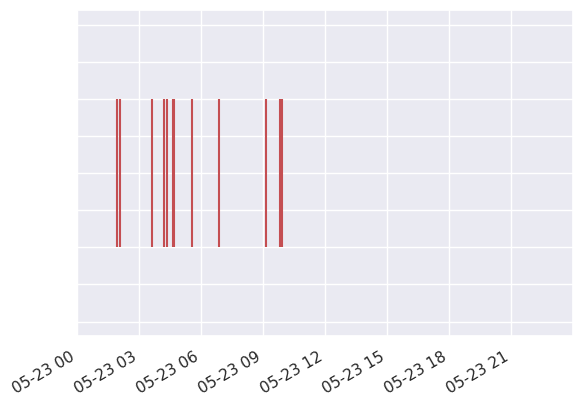

In [168]:
#| warning: false
#| label: fig-eventos
#| fig-cap: Visualización de eventos de SSH
fig, ax = plt.subplots()

fecha = [evento[1] for evento in eventos]
etiquetas = [evento[0] for evento in eventos]
ax.eventplot(fecha, lineoffsets=0.1, linelengths=0.1, color='r')
ax.set_ylabel(None)
ax.set_yticklabels([])
ax.set_xlim(datetime(2023, 5, 23, 0, 0), datetime(2023, 5, 23, 23, 59))
fig.autofmt_xdate()


### Análisis de ISPs

In [169]:
recuento = df["isp"].value_counts().to_dict()

recuento = pd.DataFrame(data={"ISP": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,ISP,Reportes
0,DigitalOcean LLC,3
1,ChinaNet Jiangsu Province Network,2
2,Amazon Data Services NoVa,1
3,KT Corporation,1
4,Pacswitch Globe Telecom Limited,1
5,Vodafone Italia S.p.A.,1
6,FiberXpress BV,1
7,Alibaba.com Singapore E-Commerce Private Limited,1
8,Chunghwa Telecom Co. Ltd.,1


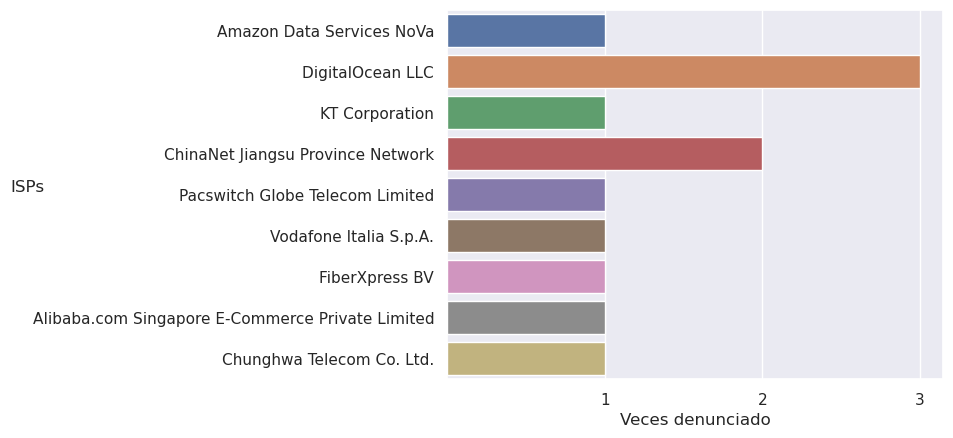

In [170]:
#| label: fig-isps
#| fig-cap: Número de veces que se denuncio un ISp
fig=plt.plot(figsize=(15, 10))
sns.countplot(data=df, y="isp")
plt.tick_params(labelsize = 11)
plt.xticks([1,2,3])
plt.ylabel("ISPs", rotation=0)
plt.xlabel("Veces denunciado")
plt.show()

### Análisis de uso

In [173]:
recuento = df["tipoDeUso"].value_counts().to_dict()

recuento = pd.DataFrame(data={"uso": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,uso,Reportes
0,Data Center/Web Hosting/Transit,8
1,Fixed Line ISP,1


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       12 non-null     int64 
 1   ip               12 non-null     object
 2   esPublica        12 non-null     bool  
 3   estaEnWhitelist  12 non-null     bool  
 4   scoreAbuso       12 non-null     int64 
 5   pais             12 non-null     object
 6   codigoPais       12 non-null     object
 7   isp              12 non-null     object
 8   tipoDeUso        9 non-null      object
 9   ultimoReporte    12 non-null     object
dtypes: bool(2), int64(2), object(6)
memory usage: 920.0+ bytes


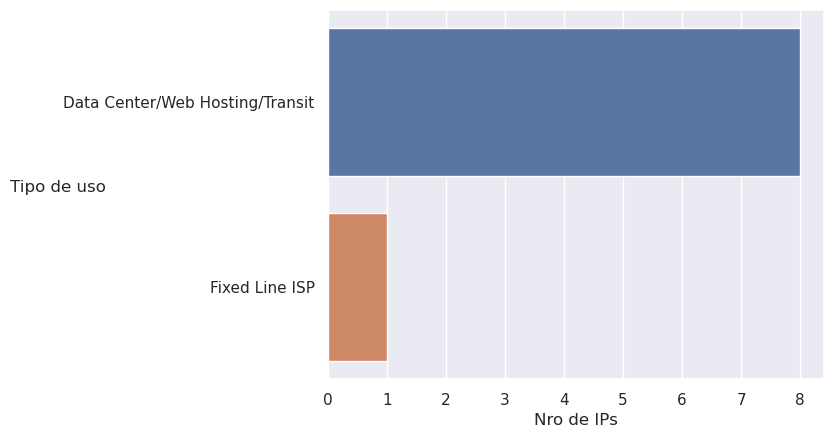

In [176]:
#| label: fig-tipodeusoSSH
#| fig-cap: Tipo de uso declarado por las IPs
fig=plt.plot(figsize=(15, 10))
sns.countplot(data=df, y="tipoDeUso")
plt.tick_params(labelsize = 11)
#plt.xticks([1,2,3])
plt.ylabel("Tipo de uso", rotation=0)
plt.xlabel("Nro de IPs")
plt.show()

## Análisis de IPs reportadas por ataque DDoS
### Extracción de información

In [178]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/DDOS.txt > data/IPsDDoS.txt

patron = "[a-z]{3}\/[0-9]{2}\/[0-9]{4}"
!grep -Eo "$patron" data/DDOS.txt >> data/IPsDDoS.txt

patron = "[0-9]{2}\:[0-9]{2}\:[0-9]{2}"
!grep -Eo "$patron" data/DDOS.txt >> data/IPsDDoS.txt

In [179]:
with open("data/IPsDDoS.txt") as ips:
    data = ips.read()
    data = data.replace("\n", " ").split()

In [180]:
ips = []
dia = []
hora = []
for i in range(int(len(data)/3)):
    ips.append(data[i])
    dia.append(data[int(len(data)/3)+i])
    hora.append(data[(int(len(data)/3))*2+i])
    data[i] = data[i] + " " + data[int(len(data)/3)+i] + " " + data[(int(len(data)/3))*2+i]

In [181]:
data = data[:int(len(data)/3)]

In [182]:
for i in range(6):
    print(data[i])
    print(data[len(data)-1-i])

45.204.126.117 may/22/2023 23:47:10
43.225.58.19 may/22/2023 23:47:19
59.153.100.70 may/22/2023 23:47:10
103.119.129.64 may/22/2023 23:47:19
1.32.249.141 may/22/2023 23:47:10
43.225.58.182 may/22/2023 23:47:19
103.116.15.134 may/22/2023 23:47:10
43.225.58.88 may/22/2023 23:47:19
43.225.58.180 may/22/2023 23:47:10
43.225.58.251 may/22/2023 23:47:19
64.112.28.230 may/22/2023 23:47:10
174.136.237.68 may/22/2023 23:47:19


In [183]:
data = pd.DataFrame(data={'ip': ips,
                       'dia': dia,
                       'hora': hora})
data

,ip,dia,hora
0,45.204.126.117,may/22/2023,23:47:10
1,59.153.100.70,may/22/2023,23:47:10
2,1.32.249.141,may/22/2023,23:47:10
3,103.116.15.134,may/22/2023,23:47:10
4,43.225.58.180,may/22/2023,23:47:10
...,...,...,...
373,43.225.58.251,may/22/2023,23:47:19
374,43.225.58.88,may/22/2023,23:47:19
375,43.225.58.182,may/22/2023,23:47:19
376,103.119.129.64,may/22/2023,23:47:19


In [184]:
apiAbuse = AbuseIPDB()

In [185]:
#Declaro las keys de la info que devuelve mi implementación de requests
keys = ['esPublica', 'estaEnWhitelist', 'scoreAbuso', 'pais', 'codigoPais', 'isp', 'uso', 'ultimoReporte']

diccDf = {'ip' : []}

if os.path.isfile("data/ipDDOS.csv"):
    
    df = pd.read_csv("data/ipDDOS.csv")
    
else:
    for ip in ips:
        diccDf['ip'].append(ip)
        info = apiAbuse.getInfo(ip)
        for key in keys:
            if key in diccDf:
                diccDf[key].append(info[key])
            else:
                diccDf[key] = [info[key]]

    df = pd.DataFrame(data=diccDf)
df["hora"] = data["hora"]
df["dia"] = data["dia"]

In [186]:
df

,Unnamed: 0,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp,uso,ultimoReporte,hora,dia
0,0,45.204.126.117,True,NaN,0,NaN,HK,Intercontinental Internet Data Corp,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
1,1,59.153.100.70,True,NaN,0,NaN,BD,Dot Internet,Fixed Line ISP,NaN,23:47:10,may/22/2023
2,2,1.32.249.141,True,NaN,0,NaN,HK,CTG Server Ltd.,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
3,3,103.116.15.134,True,NaN,0,NaN,TW,Shine Telecom Co. Ltd.,Commercial,NaN,23:47:10,may/22/2023
4,4,43.225.58.180,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
...,...,...,...,...,...,...,...,...,...,...,...,...
373,373,43.225.58.251,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
374,374,43.225.58.88,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
375,375,43.225.58.182,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
376,376,103.119.129.64,True,NaN,0,NaN,HK,Suniway Group Limited,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023


In [187]:
if "Unnamed: 0" in df:
    df.drop("Unnamed: 0", axis=1, inplace=True)

In [188]:
df

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp,uso,ultimoReporte,hora,dia
0,45.204.126.117,True,NaN,0,NaN,HK,Intercontinental Internet Data Corp,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
1,59.153.100.70,True,NaN,0,NaN,BD,Dot Internet,Fixed Line ISP,NaN,23:47:10,may/22/2023
2,1.32.249.141,True,NaN,0,NaN,HK,CTG Server Ltd.,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
3,103.116.15.134,True,NaN,0,NaN,TW,Shine Telecom Co. Ltd.,Commercial,NaN,23:47:10,may/22/2023
4,43.225.58.180,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
...,...,...,...,...,...,...,...,...,...,...,...
373,43.225.58.251,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
374,43.225.58.88,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
375,43.225.58.182,True,NaN,0,NaN,HK,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
376,103.119.129.64,True,NaN,0,NaN,HK,Suniway Group Limited,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023


In [189]:
df.to_csv("data/ipDDOS.csv")

### Índices de abuso

In [190]:
recuento = df["scoreAbuso"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,0,375
1,2,2
2,10,1


### Análisis de procedencia

In [191]:
import pycountry

In [192]:
df['pais'] = df['codigoPais'].apply(lambda codigo: pycountry.countries.get(alpha_2=codigo).name)
dfgdp = df.copy()
dfgdp['codigoPais'] = df['pais'].apply(lambda nombre: pycountry.countries.search_fuzzy(nombre)[0].alpha_3)

In [193]:
dfgdp

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp,uso,ultimoReporte,hora,dia
0,45.204.126.117,True,NaN,0,Hong Kong,HKG,Intercontinental Internet Data Corp,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
1,59.153.100.70,True,NaN,0,Bangladesh,BGD,Dot Internet,Fixed Line ISP,NaN,23:47:10,may/22/2023
2,1.32.249.141,True,NaN,0,Hong Kong,HKG,CTG Server Ltd.,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
3,103.116.15.134,True,NaN,0,"Taiwan, Province of China",TWN,Shine Telecom Co. Ltd.,Commercial,NaN,23:47:10,may/22/2023
4,43.225.58.180,True,NaN,0,Hong Kong,HKG,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
...,...,...,...,...,...,...,...,...,...,...,...
373,43.225.58.251,True,NaN,0,Hong Kong,HKG,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
374,43.225.58.88,True,NaN,0,Hong Kong,HKG,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
375,43.225.58.182,True,NaN,0,Hong Kong,HKG,Dragon Spirit Investments International Co. Li...,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023
376,103.119.129.64,True,NaN,0,Hong Kong,HKG,Suniway Group Limited,Data Center/Web Hosting/Transit,NaN,23:47:19,may/22/2023


In [194]:
import geopandas as gpd
import matplotlib.pyplot as plt

mapa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [195]:
print(np.unique(dfgdp["codigoPais"].loc[~dfgdp["codigoPais"].isin(mapa["iso_a3"])]))

['HKG']


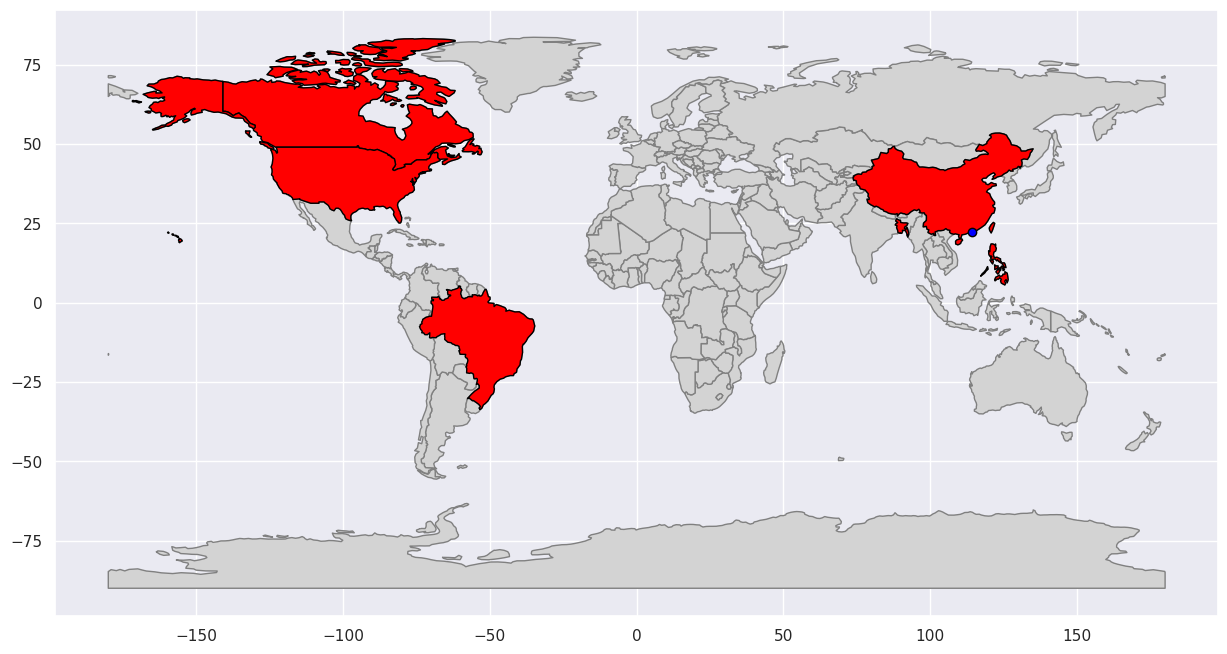

In [196]:
#| label: fig-mapaDDoS
#| fig-cap: Mapa con los lugares del que proceden las IPs
paisesMarcados = mapa[mapa['iso_a3'].isin(dfgdp["codigoPais"])]

fig, ax = plt.subplots(figsize=(15, 10))

mapa.plot(ax=ax, edgecolor='grey', color='lightgrey')
paisesMarcados.plot(ax=ax, edgecolor='black', color='red')

ciudades = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

hongkong = ciudades[ciudades['name'] == 'Hong Kong']

hongkong.plot(ax=ax, edgecolor='black', color='blue')

plt.show()

In [197]:
#| code-fold: true
recuento = df["pais"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,Hong Kong,174
1,Philippines,118
2,China,75
3,United States,5
4,Canada,3
5,Bangladesh,1
6,"Taiwan, Province of China",1
7,Brazil,1


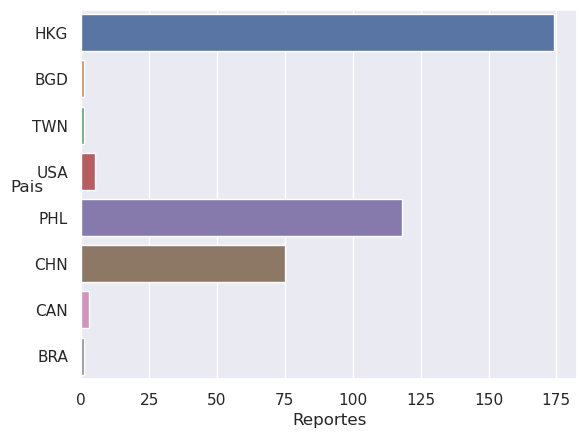

In [198]:
#| label: fig-countplotDDoS
#| fig-cap: Pais vs Nro de reportes
sns.set(style='darkgrid')
sns.countplot(data=dfgdp, y="codigoPais")
ylabel = plt.ylabel("Pais", rotation='horizontal')
plt.xlabel("Reportes")
plt.show()

In [199]:
recuento = dfgdp["codigoPais"].value_counts().to_dict()

dfPlot = pd.DataFrame(data={"codigoPais": list(recuento.keys()), "Reportes": list(recuento.values())})
dfPlot

fig = px.scatter_geo(dfPlot, locations="codigoPais", color="codigoPais", size="Reportes",
                     projection="equirectangular")
fig.write_image("data/plotlyDDoS.png")

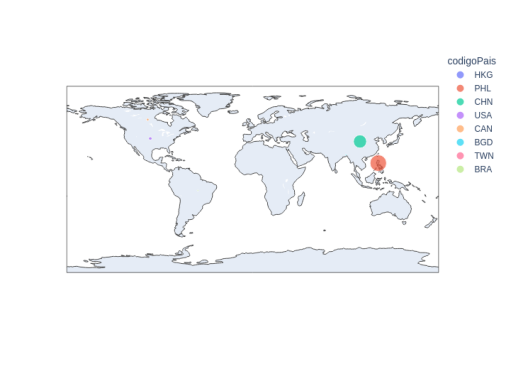

In [213]:
#| label: fig-scatergeoDDoS
#| fig-cap: Scatterplot con tamaño en función de número de reportes
from PIL import Image 

image = np.asarray(Image.open('data/plotlyDDoS.png'))
plt.imshow(image)
plt.grid(False)
plt.axis(False)
plt.show()

### Análisis de frecuencia
Para así poder de tratar de identificar cierto patron asociado a la hora de ataque. 

#### Extracción de información

In [201]:
df.head(3)

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp,uso,ultimoReporte,hora,dia
0,45.204.126.117,True,NaN,0,Hong Kong,HK,Intercontinental Internet Data Corp,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023
1,59.153.100.70,True,NaN,0,Bangladesh,BD,Dot Internet,Fixed Line ISP,NaN,23:47:10,may/22/2023
2,1.32.249.141,True,NaN,0,Hong Kong,HK,CTG Server Ltd.,Data Center/Web Hosting/Transit,NaN,23:47:10,may/22/2023


In [202]:
eventosDDoS = []
for index, row in df.iterrows():
    fecha = row["dia"].split(sep="/")
    if fecha[0] != 'may':
        print(fecha[0])
    else:
        mes = 5
        
    dia = fecha[1]
    año = fecha[2]
    
    tiempo = row["hora"].split(sep=":")
    hora = tiempo[0]
    minuto = tiempo[1]
    eventosDDoS.append((row["ip"], datetime(int(año), int(mes), int(dia), int(hora), int(minuto))))


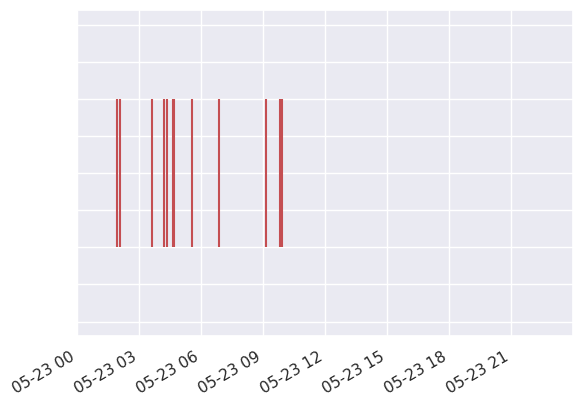

In [203]:
#| warning: false
#| label: fig-eventosDDoS
#| fig-cap: Visualización de eventos de DDoS
fig, ax = plt.subplots()

fecha = [evento[1] for evento in eventos]
etiquetas = [evento[0] for evento in eventos]
ax.eventplot(fecha, lineoffsets=0.1, linelengths=0.1, color='r')
ax.set_ylabel(None)
ax.set_yticklabels([])
ax.set_xlim(datetime(2023, 5, 23, 0, 0), datetime(2023, 5, 23, 23, 59))
fig.autofmt_xdate()

Notar que a comparación de los por SSH parecen menos siendo que son 380 ataques contra 12. Esto es porque son muy seguido.

### Análisis de ISPs

In [204]:
recuento = df["isp"].value_counts().to_dict()

recuento = pd.DataFrame(data={"ISP": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,ISP,Reportes
0,Suniway Group Limited,75
1,Gold Experience Cloud LLC,75
2,Dragon Spirit Investments International Co. Li...,73
3,WTW Hightech Company Inc,67
4,Suniway Telecom,39
5,Suniway Group of Companies Inc.,36
6,Intercontinental Internet Data Corp,1
7,Bell Canada,1
8,Comcast Cable Communications LLC,1
9,Cabo Servicos de Telecomunicacoes Ltda,1


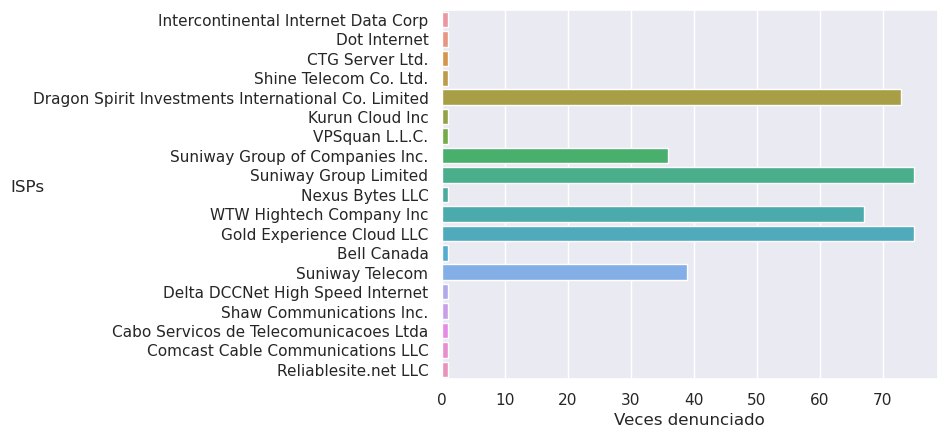

In [205]:
#| label: fig-ispsDDoS
#| fig-cap: Número de veces que se denuncio un ISP por ataque DDoS
fig=plt.plot(figsize=(15, 10))
sns.countplot(data=df, y="isp")


    
plt.tick_params(labelsize = 11)
#plt.xticks([1,2,3])
plt.ylabel("ISPs", rotation=0)
plt.xlabel("Veces denunciado")
plt.show()


### Análisis de uso

In [207]:
recuento = df["uso"].value_counts().to_dict()

recuento = pd.DataFrame(data={"uso": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,uso,Reportes
0,Data Center/Web Hosting/Transit,335
1,Fixed Line ISP,42
2,Commercial,1


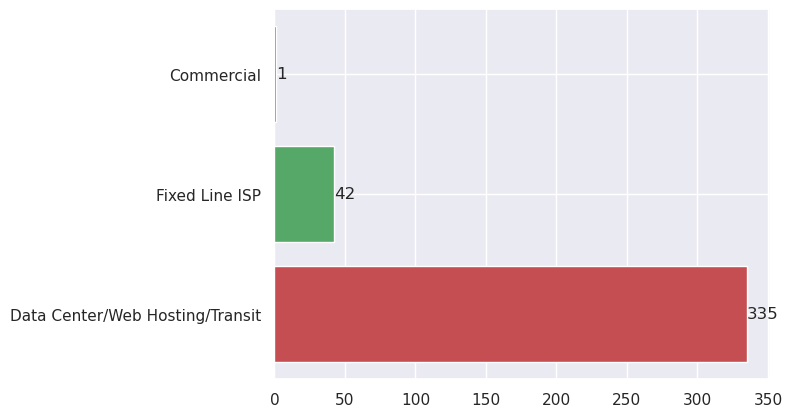

In [212]:
fig, ax = plt.subplots()

# Graficar las barras intercambiando los ejes
ax.barh(recuento['uso'], recuento['Reportes'], color=['r', 'g', 'b'])

# Agregar etiquetas al final de cada barra
for i, v in enumerate(recuento['Reportes']):
    ax.text(v, i, str(v), ha='left', va='center')
